**Facebook Open Source NeuralProphet: Automatic Forecasting Procedure**

NeuralProphet is the new Facebook’s updated version of Prophet and allows users to use simple but powerful deep learning models such as AR-Net for forecasting tasks. What makes NeuralProphet unique is its ability to incorporate additional information such as trends, seasonality, and recurring events into account when generating forecasts and during fitting.

In [1]:
!pip install neuralprophet

     |████████████████████████████████| 61kB 6.5MB/s 
     |████████████████████████████████| 81kB 8.2MB/s 
     |████████████████████████████████| 748.8MB 20kB/s 
ERROR: torchvision 0.9.1+cu101 has requirement torch==1.8.1, but you'll have torch 1.6.0 which is incompatible.
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.6.0 which is incompatible.
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101


In [2]:
import requests
import pandas as pd
from datetime import datetime, timedelta
from neuralprophet import NeuralProphet

import matplotlib.pyplot as plt
plt.style.use('default')

import warnings
warnings.filterwarnings("ignore")

In [3]:
market = 'BTC-GBP'
granularity = 3600

In [4]:
def getHistoricalData(market: str='BTC-GBP', granularity: int=3600, iso8601start: str='', iso8601end: str='') -> pd.DataFrame:
  if iso8601start != '' and iso8601end == '':
    resp = requests.get(f'https://api.pro.coinbase.com/products/{market}/candles?granularity={granularity}&start={iso8601start}')
  elif iso8601start != '' and iso8601end != '':
    resp = requests.get(f'https://api.pro.coinbase.com/products/{market}/candles?granularity={granularity}&start={iso8601start}&end={iso8601end}')
  else:
    resp = requests.get(f'https://api.pro.coinbase.com/products/{market}/candles?granularity={granularity}')

  df = pd.DataFrame.from_dict(resp.json())
  df.columns = [ 'epoch','low','high','open','close','volume' ]
  df['adj close'] = df['close']

  tsidx = pd.DatetimeIndex(pd.to_datetime(df['epoch'], unit='s'), dtype='datetime64[ns]')
  df.set_index(tsidx, inplace=True)
  df = df.drop(columns=['epoch'])
  df.index.names = ['date']

  return df.iloc[::-1].reset_index()

In [5]:
def getHistoricalDataChained(market: str='BTC-GBP', granularity: int=3600, max_interations: int=1) -> pd.DataFrame:
  df1 = getHistoricalData(market, granularity)

  if max_interations == 1:
    return df1

  def getPreviousDateRange(df: pd.DataFrame=None) -> tuple:
    end_date = df['date'].min() - timedelta(seconds=(granularity / 60))
    new_start = df['date'].min() - timedelta(hours=300)
    return (str(new_start).replace(' ', 'T'), str(end_date).replace(' ', 'T'))

  iterations = 0
  result_df = pd.DataFrame()
  while iterations < (max_interations - 1):
    start_date, end_date = getPreviousDateRange(df1)
    df2 = getHistoricalData(market, granularity, start_date, end_date)
    result_df = pd.concat([df2, df1]).drop_duplicates()
    df1 = result_df
    iterations = iterations + 1

  if 'date'in result_df:
    result_df.sort_values(by=['date'], ascending=True, inplace=True)
        
  return result_df

In [6]:
df = getHistoricalDataChained(market, granularity, 30) # 1 year
df.shape

(8998, 7)

In [7]:
df.head()

,date,low,high,open,close,volume,adj close
0,2020-06-07 23:00:00,7662.45,7715.98,7705.46,7676.69,10.691386,7676.69
1,2020-06-08 00:00:00,7668.63,7704.46,7680.00,7700.12,10.765678,7700.12
2,2020-06-08 01:00:00,7685.13,7712.00,7700.12,7692.89,10.705966,7692.89
3,2020-06-08 02:00:00,7659.51,7700.36,7700.36,7661.10,1.954273,7661.10
4,2020-06-08 03:00:00,7660.00,7676.50,7665.50,7670.70,1.847173,7670.70


In [15]:
df1 = df[[ 'date','adj close' ]]
df1.dropna(inplace=True)
df1.columns = [ 'ds', 'y' ]
df1.head()

,ds,y
0,2020-06-07 23:00:00,7676.69
1,2020-06-08 00:00:00,7700.12
2,2020-06-08 01:00:00,7692.89
3,2020-06-08 02:00:00,7661.10
4,2020-06-08 03:00:00,7670.70


In [16]:
model = NeuralProphet(
    n_forecasts=60,
    n_lags=60,
    n_changepoints=50,
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    batch_size=64,
    epochs=100,
    learning_rate=1.0,
)

metrics = model.fit(df1, freq="H")

INFO: nprophet - _handle_missing_data: 2 missing dates were added.
INFO: nprophet - _handle_missing_data: 2 NaN values in column y were auto-imputed.
Epoch[100/100]: 100%|██████████| 100/100 [01:15<00:00,  1.32it/s, SmoothL1Loss=0.000345, MAE=690, RegLoss=0]


In [17]:
#help(NeuralProphet)

INFO: nprophet - _handle_missing_data: 2 missing dates were added.
INFO: nprophet - _handle_missing_data: 2 NaN values in column y were auto-imputed.


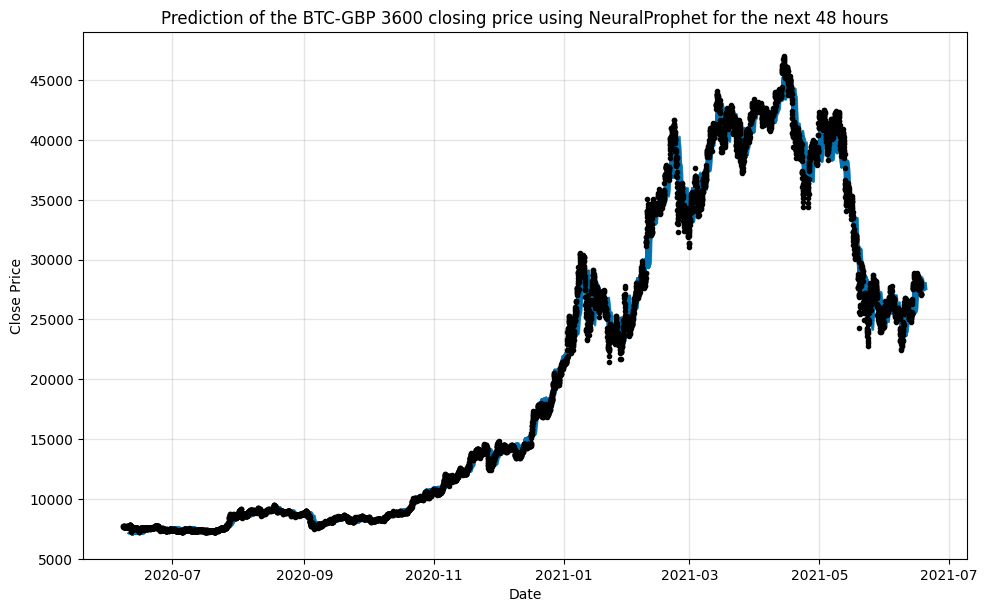

In [18]:
# predictions
future = model.make_future_dataframe(df1, periods=48, n_historic_predictions=len(df1))
prediction = model.predict(future)

# plotting
forecast = model.plot(prediction)
plt.title(f"Prediction of the {market} {granularity} closing price using NeuralProphet for the next 48 hours")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()

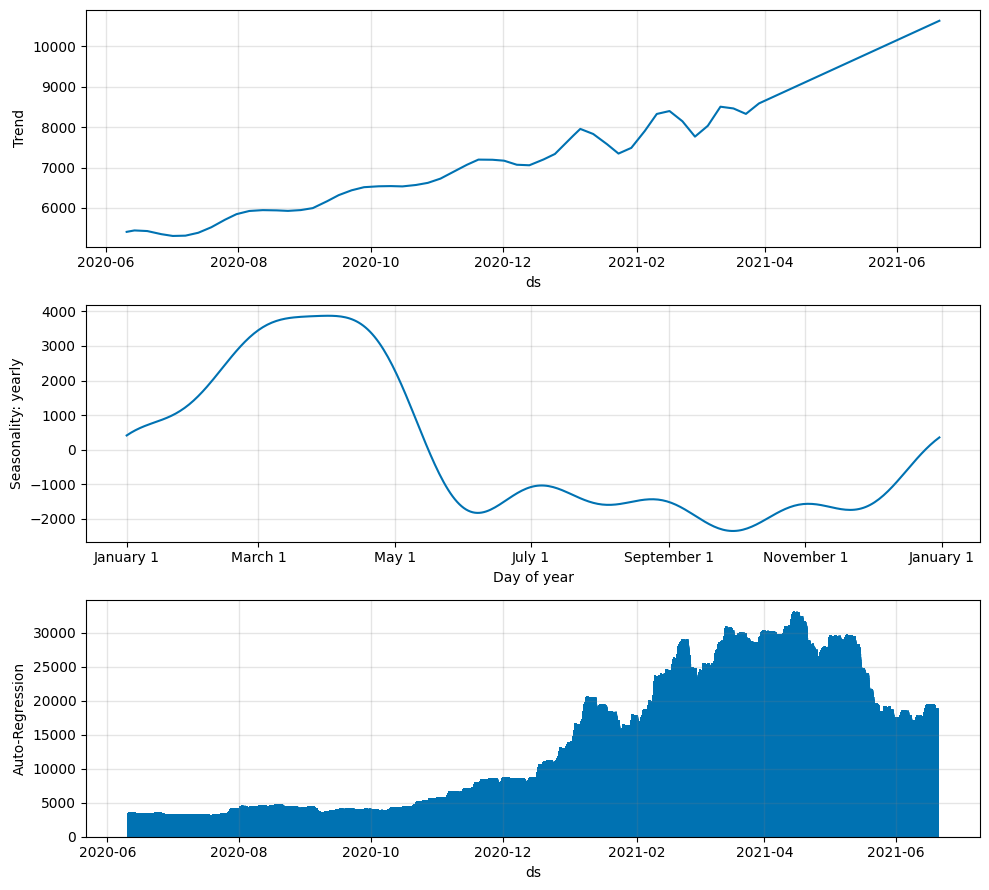

In [19]:
model.plot_components(prediction)
plt.show()